In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from resources.polynomial_reduction_mod2 import *
from resources.QROM_polynomial_reduction import *
import matplotlib.pyplot as plt

## a) Introduction
Here we investigate an approach to building a SELECT-style Quantum ROM for boolean functions $f: \mathbb{F}_2^n \rightarrow \mathbb{F}_2$ that aims to improve on circuit complexity over the naive SELECT implementation. Like the naive implementation, this approach does not use using ancillae, and the resulting circuit $U$ is such that
$$
U \left|x\right>_n \left|y\right>_1 = \left|x\right>_n \left|y \oplus f(x)\right>_1.
$$

Our approach, inspired by ([Mukhopadhyay 2025](https://www.nature.com/articles/s41598-025-95283-5)), represents the function as a polynomial over the input bits and reduces that polynomial before converting it into a circuit. As we show explicitly for boolean functions on $n=3$ and $n=4$ bits (see __(d) Exhaustive Comparison with the Naive Implementation__), the resulting circuit in the majority of cases is less complex than that from the naive implementation, in the sense that it uses fewer multi-controlled $X$ gates and/or uses multi-controlled $X$ gates with fewer control qubits. In our approach, we specifically aim to minimize the total number of control qubits across all multi-controlled X gates - what we will call the number of 'control points'. Given that multi-controlled X gates can be implemented with circuit depth linear in the number of controls ([Saeedi and Pedram 2013](http://arxiv.org/abs/1303.3557)), this heuristic roughly optimizes for depth of the circuit within the specific class of circuits considered here (discussed under __(a.ii) Circuit Class__ below). 

### a.i) Motivating Example

As an example, consider the function $f$ on length $4$ bit strings that maps $0001$, $0011$, and $0101$ to $1$ and all other bit strings to $0$. One can think of the naive SELECT QROM as making use of the fact that $f$ can be represented by the following boolean polynomial:

$$f(x_3 x_2 x_1 x_0) = p_{\mathrm{boolean}}(x_0, x_1, x_2, x_3) = x_0 \land \overline{x_1} \land \overline{x_2} \land \overline{x_3} \oplus x_0 \land x_1 \land \overline{x_2} \land \overline{x_3}  \oplus x_0 \land \overline{x_1} \land x_2 \land \overline{x_3}.$$

Since this polynomial contains three terms with four factors each, the naive implementation requires three multi-controlled $X$ gates with four control qubits each, i.e. three $C^4X$ gates, and a number of $X$ gates to implement the negations:

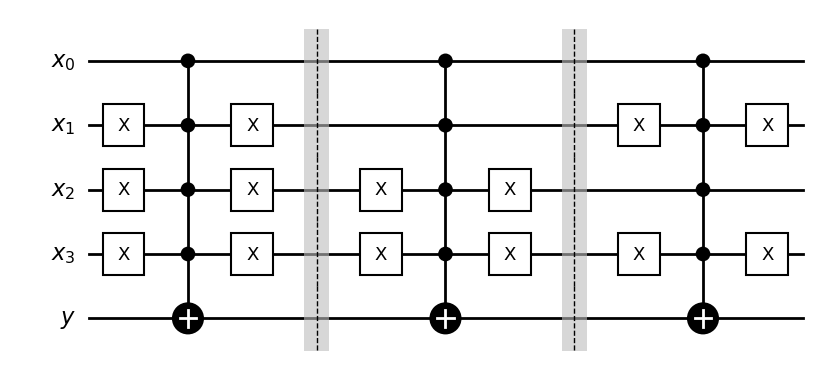

Following ([Mukhopadhyay 2025](https://www.nature.com/articles/s41598-025-95283-5)), we note that, interpreting the $x_k$ and $f$ as the numbers $0$ or $1$ instead of logical bits, the above polynomial is equivalent to

$$f(x_3 x_2 x_1 x_0) \equiv p_{\mathrm{numerical}}(x_0, x_1, x_2, \overline{x_3}) = x_0 (1+x_1) (1+x_2) \overline{x_3} + x_0 x_1 (1+x_2) \overline{x_3} + x_0 (1+x_1) x_2 \overline{x_3} \;(\mathrm{mod} 2),$$

where we have made a choice take $p_{\mathrm{numerical}}$ to depend on $x_0$, $x_1$, $x_2$, and $\overline{x_3}$. (It was also an option to use $x_3$ instead of $\overline{x_3}$ or $\overline{x_0}$ instead of $x_0$, for example.) $p_{\mathrm{numerical}}$ can be reduced via a simple procedure (detailed below) as

$$p_{\mathrm{numerical}}(x_0, x_1, x_2, x_3) = x_0 \overline{x_3} + x_0 x_1 x_2 \overline{x_3} \;(\mathrm{mod} 2).$$

Equivalently, in boolean form,

$$p_{\mathrm{boolean}}(x_0, x_1, x_2, x_3) = x_0 \land \overline{x_3}  \oplus x_0 \land x_1 \land x_2 \land \overline{x_3},$$

which can be implemented with only two $X$ gates, a $C^2X$, and a $C^4X$ gate:

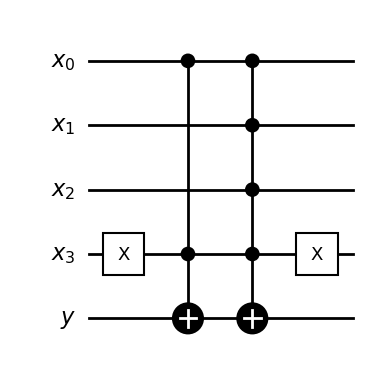

This circuit has $6$ total 'control points', as compared with $12$ for the naive circuit, and so has a depth that is roughly half.

### a.ii) Circuit Class

In this implementation, we restrict the resulting polynomial to be such that each input bit appears either only negated (like $x_3$ in the example above) or only un-negated (like $x_0$, $x_1$, and $x_2$). We will make the choice of which bits are negated and which are un-ngegated ahead of time, before generating the polynomial, and thus for each function $f$, there will be up to $2^n$ different associated polynomials. It will be over that space of $2^n$ polynomials that we can optimize the circuit complexity.

Under this restriction, the resulting circuit will always have a structure like that in the example above: first $X$ gates on the subset of the input qubits to be negated, then a number of multi-controlled $X$ gates that control the output qubit - one for each monomial in the reduced polynomial, and finally another set of $X$ gates that reverse the action of the first.

## b) Polynomial Reduction - Implementation Details
Here we will discuss the implementation of the polynomial reduction by following the example above.

### b.i) Representation of the Function $f$ and the Monomials in $p_{\mathrm{boolean}}$
The boolean function $f: \mathbb{F}_2^n \rightarrow \mathbb{F}_2$ is completely specified by the set of input bit strings that map to a value of $1$. In this code, we represent $f$ by a list of non-negative integers among $\{0,1,\ldots 2^n -1\}$, whose binary representations match those bit strings. For the example above, the set of input bit strings was $0001$, $0011$, and $0101$, and so the list of integers is $1$, $3$, and $5$:

In [2]:
inputs_f_eq_1 = [1,3,5]

Each number also corresponds to a monomial in the starting form of $p_{\mathrm{boolean}}$. (This is a valid encoding, since each monomial contains all the input bits, some of which are negated. The ones in the binary form of each of these numbers identify which input bits are un-negated.)

In the following steps, we will assume that we desire the numerical polynomial to be a function of the input bits, all un-negated. We can do so without loss of generality, since - at this point - we can redefine the input bits and function in coordination to effectively negate the bits we desire. For the example above, we wanted to negate bit $3$, which is effectively done by XORing each of the input bit strings with $1000$. Equivalently, bit-wise XOR $1$, $3$, and $5$, with $1000_2 = 8$:

In [3]:
inputs_f_eq_1_after_negations = [x^8 for x in inputs_f_eq_1]
inputs_f_eq_1_after_negations

[9, 11, 13]

For clarity, we will label the new, effective set of input bits with $u$: $u_0=x_0$, $u_1=x_1$, $u_2=x_2$, and $u_3 = \overline{x_3}$. And we will label the new, effective function and polynomials with tildes: $\tilde{f}(u_3u_2u_1u_0)$ is $1$ exactly when $u_3u_2u_1u_0$ is $1001_2 \equiv 9$, $1011_2 \equiv 11$, or $1101_2 \equiv 13$, and so 
$$
\tilde{p}_{\mathrm{boolean}}(u_0, u_1, u_2, u_3) = u_0 \land \overline{u_1} \land \overline{u_2} \land u_3 \oplus u_0 \land u_1 \land \overline{u_2} \land u_3  \oplus u_0 \land \overline{u_1} \land u_2 \land u_3
$$
and
$$
\tilde{p}_{\mathrm{numerical}}(u_0, u_1, u_2, u_3) = u_0 (1+u_1) (1+u_2) u_3 + u_0 u_1 (1+u_2) u_3 + u_0 (1+u_1) u_2 u_3 \;(\mathrm{mod} 2).
$$

Note that, once a choice of either negating each input bit or not is made, and the above conversion is done, the resulting list of numbers also uniquely represent the terms that appear in this form of $\tilde{p}_{\mathrm{numerical}}$. Those terms are, however, not necessarily monomials. In fact, none of the terms in this example are!

### b.iii) Expanding the Terms in $\tilde{p}_{\mathrm{numerical}}$ into Monomials
The reduction of $\tilde{p}_{\mathrm{numerical}}$ proceeds by first expanding all its terms into monomials. For the first term in this example, expanding by hand would give
$$
u_0 u_3 + u_0 u_1 u_3 + u_0 u_2 u_3 + u_0 u_1 u_2 u_3.
$$
This immediately begs two questions:
- How do we represent the resulting monomials in code?
- How do we automate the process of expanding into monomials?

#### Representing Monomials in $\tilde{p}_{\mathrm{numerical}}$
Note that, operating modulo $2$, each monomial is uniquely determined by which input bits it contains. Represent each monomial by a integer whose binary representation picks out those input bits are in that monomial. For the four monomials above, the numbers would be $1001_2 \equiv 9$, $1011_2 \equiv 11$, $1101_2 \equiv 13$, and $1111_2 \equiv 15$. 

#### Automating the Expansion of Terms in $\tilde{p}_{\mathrm{numerical}}$

Note that the terms resulting from expanding the first term are all possible monomials (modulo $2$) involving $u_0$, $u_1$, $u_2$, and $u_3$ that contain at least $u_0$ and $u_3$. As is pointed out in ([Mukhopadhyay 2025](https://www.nature.com/articles/s41598-025-95283-5)), this is true generally: the set of monomials is the minimal one (here $u_0 u_3$) times all possible combinations of the remaining variables. Recall that $u_0$ and $u_3$ are the input bits that were un-negated in this term of the boolean polynomial, as reflected by the number $9 \equiv 1001_2$ in `inputs_f_eq_1`. To generate the representations of the four monomials from $9$, we must consider all possible replacements of $0$'s in the binary representation of $9$ with $0$'s or $1$'s. This is implemented in the function `expand_monomials_from_number` in resources/polynomial_reduction_mod2.py. For the four terms in the starting form of $\tilde{p}_{\mathrm{numerical}}$, here are the integer representations of the resulting monomials:

In [4]:
n = 4
print(f"{'x s.t. f(x) = 1':<15}{'|':^5}{'Resulting Monomials':<20}")
print('---------------------------------------')
for x in inputs_f_eq_1_after_negations:
    print(f"{str(x):<15}{'|':^5}{str(expand_monomials_from_number(x,n)):<20}")

x s.t. f(x) = 1  |  Resulting Monomials 
---------------------------------------
9                |  [9, 11, 13, 15]     
11               |  [11, 15]            
13               |  [13, 15]            


### b.iv) Reducing $\tilde{p}_{\mathrm{numerical}}$ Modulo $2$
Note that $\tilde{p}_{\mathrm{numerical}}$ is to be evaluated modulo $2$. If the same monomial appears an even number of times, their sum is equivalent to $0$. And if it appears an odd number of times, the sum is equivalent to one copy of that monomial. This is the mechanism by which the polynomial may possibly be simplified. In terms of implementation, we maintain a running list of the monomials in $\tilde{p}_{\mathrm{numerical}}$ and consider each monomial generated by each number in `inputs_f_eq_1`. If the monomial is already in the running list, discard it, and, otherwise, we add it to the list. This is implemented in the function `get_monomials_mod2` in resources/polynomial_reduction_mod2.py. For the example above:

In [5]:
monomials_reduced = get_monomials_mod2(inputs_f_eq_1_after_negations, n)
monomials_reduced

[9, 15]

## c) QROM Circuit - Implementation Details
### c.i) Basic Circuit with Prescribed Input Bit Negations
The list of monomials after reduction of $\tilde{p}_{\mathrm{numerical}}$, plus a record of which input bits were originally negated is all that required to build a QROM circuit.

In [6]:
x_reg = QuantumRegister(size=n, name='x')
y_reg = AncillaRegister(size=1, name='y')
qrom_qc = QuantumCircuit(x_reg, y_reg, name='QROM')

There are three stages in the circuit:
- a set of $X$ gates on the input qubits, one for each bit that was originally negated

In [7]:
qrom_qc.x(x_reg[3]);

- one multi-controlled $X$ gate for each monomial. The the gate is controlled by each of the input qubits in the monomial and acts on the output qubit:

In [8]:
for m in monomials_reduced:
    # get the locations k of the 1's in the binary representation of m
    _, k = get_bit_inds(m,n)
    # ... and apply a multi-controlled X controlled by the x_k
    qrom_qc.mcx(x_reg[k], y_reg[0])

- another (identical) set of $X$ gates on the input qubits, to undo the action of the first set

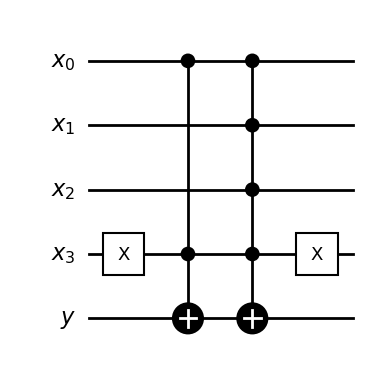

In [9]:
qrom_qc.x(x_reg[3])
qrom_qc.draw(output="mpl", style="bw")

### c.ii) Another Example - Same Function, A Different Initial Bit Negation
All of the above is encapsulated in the function `get_QROM_reduced_circuit` which takes in the function specification and desired initial input bit negation. Here is the circuit for the same function with $x_2$ negated instead of $x_3$ (achieved by setting flip_spec = $0100_2 \equiv 4$):

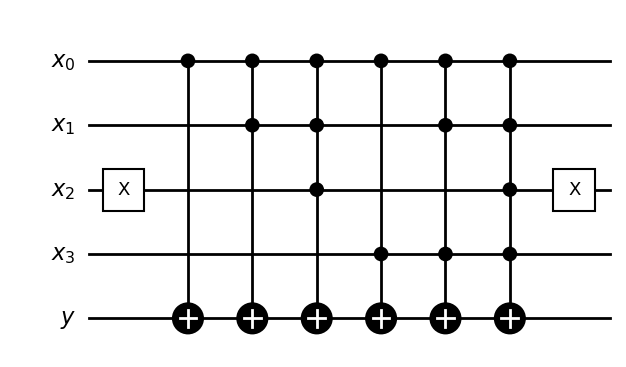

In [10]:
inputs_f_eq_1 = [1,3,5]
n=4

qrom_qc2 = get_QROM_reduced_circuit(inputs_f_eq_1, n, optimize_flips = False, flip_spec = 4)
qrom_qc2.draw(output="mpl", style="bw")

Clearly, this choice produces a far less efficient circuit. It even has more 'control points' than the naive implementation! 
### c.iii) Optimization of Input Bit Negations
To optimize the circuit complexity we simply perform a brute-force over all the $2^n$ possible initial bit negations and choose the one that will produce the least number of 'control points' in the circuit. For the example function above, here is a plot of the number of control points across all initial negation specifications (makes use of the `get_control_count` function from ):

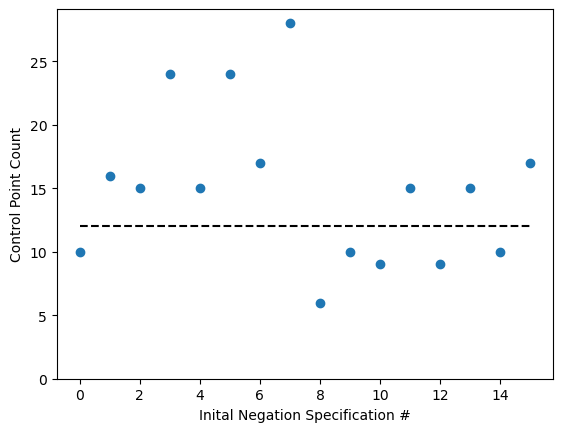

In [11]:
control_counts = []
for flip_spec in range(2**n):
    inputs_f_eq_1_after_negations = [x^flip_spec for x in inputs_f_eq_1]
    control_counts.append(get_control_count(inputs_f_eq_1_after_negations, 4))
plt.plot(control_counts,'o')
plt.plot([0,15],[12,12],'k--')
plt.xlabel('Inital Negation Specification #')
plt.ylabel('Control Point Count')
plt.ylim(ymin = 0)
plt.show()

For this example, the choice of negating $x_3$ (given by flip_spec = $8 \equiv 1000_3$) was optimal. Note that most choices produce a circuit with more 'control points' than the naive implementation, which has $12$. This optimization procedure is important! Performing the optimization is the default option in `get_QROM_reduced_circuit`.

### c.iv) A Larger Example

Here is an example for a randomly generated function on $6$ input bits with automatic optimization of the input negations:

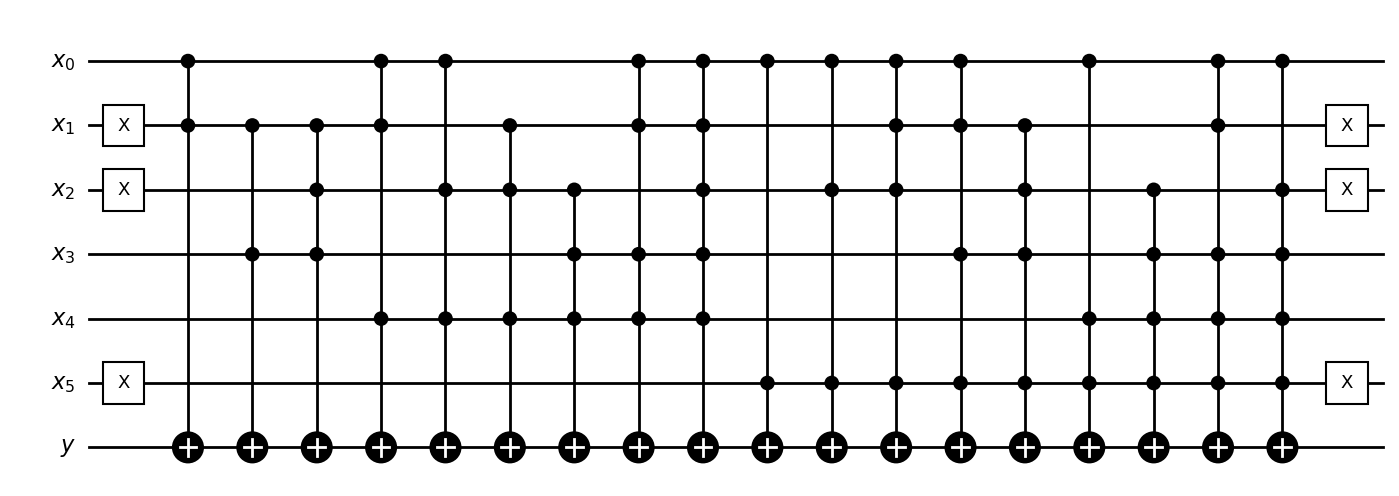

In [12]:
inputs_f2_eq_1 = [7, 8, 12, 15, 16, 27, 28, 33, 37, 41, 44, 48, 51, 57, 58, 60]
n=6
qrom_qc3 = get_QROM_reduced_circuit(inputs_f2_eq_1, n, optimize_flips = True)
qrom_qc3.draw(output="mpl", style="bw")

Since the function takes on the value of $1$ for $16$ inputs, the naive implementation would require $16$ $C^6X$ gates for a total of $96$ control points. The implementation above uses $62$.

## d) Exhaustive Comparison with the Naive Implementation
Here we consider all $2^{2^n}$ boolean functions on $n$ bits (for small $n$), and compare the 'control point' complexity of the 'polynomial reduction' and the naive implementation. Note: in the naive implementation, if more inputs result in $f=1$ than $f=0$, we allow for the simple optimization of negating the output qubit and then implementing the circuit for $\overline{f}$.

### d.i) $n=3$

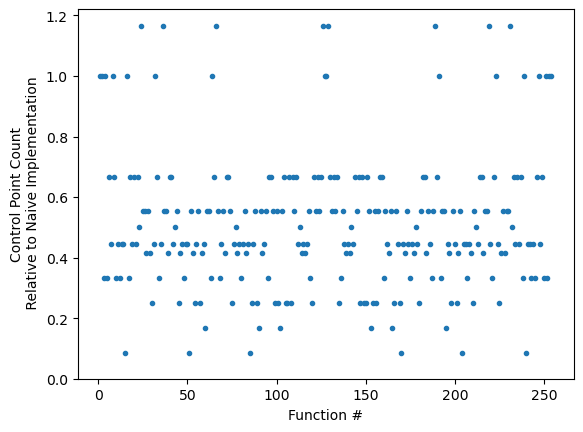

In [13]:
n = 3
control_counts_3 = np.zeros((2**(2**n),3))
for f in range(2**(2**n)):
    not_x_list, x_list = get_bit_inds(f,2**n)
    _, bf_count = brute_force_flips(x_list, n)
    control_counts_3[f,:] = [
        f, # function number
        n*min(len(x_list),len(not_x_list)), # control point count for the naive implementation
        bf_count # optimized control point count for the polynomial reduction implementation
    ]


plt.plot(control_counts_3[1:-1,0], control_counts_3[1:-1,2]/control_counts_3[1:-1,1], '.')
plt.xlabel('Function #')
plt.ylabel('Control Point Count\n Relative to Naive Implementation')
plt.ylim(ymin = 0)
plt.show()

The polynomial reduction implementation cuts the depth of the circuit in roughly half on average:

In [14]:
np.mean(control_counts_3[1:-1,2]/control_counts_3[1:-1,1])

0.5118110236220472

And it matches or improves upon the complexity of the naive implementation in $96\%$ ($246$) of the $256$ functions on $n=3$ bits:

In [15]:
np.sum(control_counts_3[1:-1,2]/control_counts_3[1:-1,1] <=1)

246

### d.ii) $n=4$

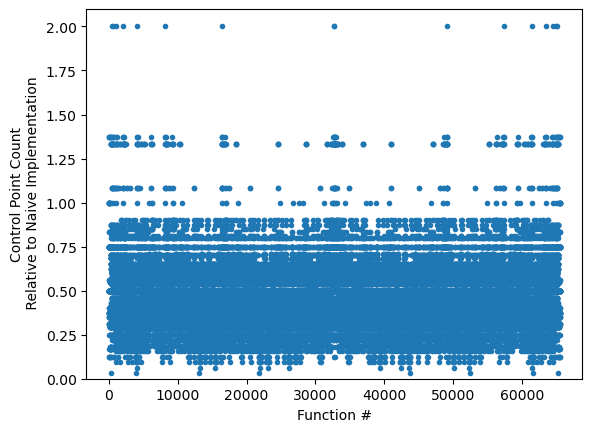

In [16]:
n = 4
control_counts_4 = np.zeros((2**(2**n),3))
for f in range(2**(2**n)):
    not_x_list, x_list = get_bit_inds(f,2**n)
    _, bf_count = brute_force_flips(x_list, n)
    control_counts_4[f,:] = [f, n*min(len(x_list),len(not_x_list)), bf_count]

plt.plot(control_counts_4[1:-1,0], control_counts_4[1:-1,2]/control_counts_4[1:-1,1], '.')
plt.xlabel('Function #')
plt.ylabel('Control Point Count\n Relative to Naive Implementation')
plt.ylim(ymin = 0)
plt.show()

For $n=4$, the average circuit depth improvement  is better than 50% :

In [17]:
np.mean(control_counts_4[1:-1,2]/control_counts_4[1:-1,1])

0.4530898537582091

And this implementation matches or improves upon the complexity of the naive implementation in $99\%$ ($65038$) of the $65536$ functions on $n=4$ bits:

In [18]:
np.sum(control_counts_4[1:-1,2]/control_counts_4[1:-1,1] <=1)

65038